## Project Motivation and Goal
There's nothing more annoying than having your Spotify listening session interrupted by a song you just don't really like. I've recently found myself pressing the "next" button on Spotify quiet often. That's why I thought to myself, "There has to be a better way." The idea for this project emerged: *Can I use my Spotify listening data to build a machine learning model that predicts whether I'm going to skip a song*.

Initially, I wanted to use Spotify's API to pull in audio analysis features for every single song (things like danceability, acousticness, energy, valence, and more). I thought these would be strong predictors. However, it turned out that in the beginning of 2025, Spotify disabled public access to that specific API endpoint.

I had to adapt and the challenge question changed to: *How accurately can I predict my Spotify skipping behavior using only the contextual data from my extended streaming history and the basic track metadata that's still available?*

## Data
I got my personal data archive by requesting my "Extended streaming history" from Spotify through my account's privacy page. A few days later, Spotify sent me a link to download a package containing several `.json` files that contain information about every song I've listened to since I created the account.

The `.json` files contain lists of events, where each event is a JSON object with detailed information about what I was listening to and when. Here is a sample event of a JSON file from 2024:

```json
{
"ts": "2024-07-11T15:32:45Z",
"platform": "ios",
"ms_played": 18333,
"conn_country": "LV",
"master_metadata_track_name": "Saturn",
"master_metadata_album_artist_name": "SZA",
"master_metadata_album_album_name": "Saturn",
"spotify_track_uri": "spotify:track:1bjeWoagtHmUKputLVyDxQ",
"episode_name": null,
"episode_show_name": null,
"spotify_episode_uri": null,
"audiobook_title": null,
"audiobook_uri": null,
"audiobook_chapter_uri": null,
"audiobook_chapter_title": null,
"reason_start": "trackdone",
"reason_end": "fwdbtn",
"shuffle": true,
"skipped": true,
"offline": false,
"offline_timestamp": 1720711945,
"incognito_mode": false
}
```

This event tells me that on July 11th, 2024, at 15:32:45 (UTC), I played SZA's *Saturn* from her *Saturn* album for 18333 milliseconds (18.333 seconds) until I skipped it. I played the song *online* on an iPhone somewhere in Latvia, having "shuffle" on. The reason I had *Saturn* playing is because the previous track had been finished playing. The reason I stopped it is because I clicked on the "forward" button. 

**Note:** Other values are less important in describing the sample event, but if you're interested in what each of them means, you should read the `JSON Value Meanings.pdf` file in the `data` folder of this project. Notice how there are three types of events in these files: songs, podcasts, and audiobooks, but for this project I focus only on songs.

**Another Note:** The `.json` files initially included an `ip_addr` key, but I removed them from all events to protect personal information.

## Converting Data Into Python Readable Format

To get a working DataFrame, I first consolidate all of the `.json` files into one dataset. In the following code cell, I iterate through the `data` folder, open each `.json` file, and extract every event into a single list. Each entry also receives an additional column called `source_file`, which records the name of the file it came from to make it easier to track potential data issues later. 

When all events are collected, I convert the list into a Pandas DataFrame called `merged_data`, which will allow me to perform all cleaning, filtering, and feature engineering operations in a unified way.

In [ ]:
# Load neccesarry libraries
import os
import json
import pandas as pd

# Define the path to the folder that stores all Spotify JSON history files
history_folder = os.path.join(os.getcwd(), "data")

# Initialize an empty list that will store all playback events from all files
all_entries = []

# Loop through every file in the 'data' directory
for filename in os.listdir(history_folder):
    file_path = os.path.join(history_folder, filename)

    # Process only JSON files
    if os.path.isfile(file_path) and filename.endswith('.json'):
        with open(file_path, 'r') as f:
            data = json.load(f)
            if isinstance(data, list):
                # Add a 'source_file' column to keep track of where each event came from
                for entry in data:
                    entry["source_file"] = filename
                
                # Extend the master list with all events from this file
                all_entries.extend(data)


# Convert and export the combined list of all events into a Pandas DataFrame
merged_data = pd.DataFrame(all_entries)
merged_data.to_csv("data/raw.csv", index=False)

After merging the `.json` files, I export the resulting DataFrame as `raw.csv` in the `data` folder. 

At some point of looking into the history files, I realized that the song events don't include information about when the song was released, which I thought could be meaningful because I tend to like newer songs more. Therefore, I initialized a Spotify API client through the `spotipy` library with credentials stored securely as environment variables (see the `fetch_data.py` file for details). The script collects all unique track URIs from the raw data, retrieves their album release dates, and maps the dates back into the main DataFrame. I saved the enriched dataset as `raw_w_release.csv`. 

Now that the song release dates have been added, I load the enriched dataset from `raw_w_release.csv` into a Pandas DataFrame called `history_data`. All subsequent steps in the notebook will be based on this dataset.

In [35]:
# Load and visualize the enriched raw_w_release.csv dataset
history_data = pd.read_csv("data/raw_w_release.csv", low_memory=False)
history_data

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,source_file,release_date
0,2017-06-20T15:37:00Z,"iOS 10.3.1 (iPhone6,2)",7383,LV,87.110.247.18,Hit This Hard,Post Malone,Stoney,spotify:track:7a2c8KeQi3LhImYQepp4Yg,NaN,...,NaN,playbtn,fwdbtn,True,False,False,NaN,False,2017_2020.json,2016-12-09
1,2017-06-20T15:37:08Z,"iOS 10.3.1 (iPhone6,2)",7198,LV,87.110.247.18,White Iverson,Post Malone,Stoney,spotify:track:1Bi5t0q9j3nYXIZuZgSGvr,NaN,...,NaN,fwdbtn,fwdbtn,True,False,False,NaN,False,2017_2020.json,2016-12-09
2,2017-06-20T15:37:08Z,"iOS 10.3.1 (iPhone6,2)",534,LV,87.110.247.18,Too Young,Post Malone,Stoney,spotify:track:5pWAuRZyAC3HIf36GfRcbz,NaN,...,NaN,fwdbtn,fwdbtn,True,False,False,NaN,False,2017_2020.json,2016-12-09
3,2017-06-20T15:37:09Z,"iOS 10.3.1 (iPhone6,2)",255,LV,87.110.247.18,Bad and Boujee (feat. Lil Uzi Vert),Migos,Culture,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,NaN,...,NaN,fwdbtn,fwdbtn,True,False,False,NaN,False,2017_2020.json,2017-04-07
4,2017-06-20T15:37:13Z,"iOS 10.3.1 (iPhone6,2)",3947,LV,87.110.247.18,Congratulations,Post Malone,Stoney,spotify:track:6syOdAs4IK8kPWR7gDyjRw,NaN,...,NaN,fwdbtn,fwdbtn,True,False,False,NaN,False,2017_2020.json,2016-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87352,2024-07-02T08:41:40Z,ios,1080,LV,2a03:ec00:b15c:64ca:4914:3fec:d98b:fa48,Illusion,Dua Lipa,Radical Optimism,spotify:track:5q0EXnBYyeCdXD72FzJxH0,NaN,...,NaN,fwdbtn,fwdbtn,True,True,False,1.719910e+09,False,2023_2024.json,2024-05-03
87353,2024-07-02T08:41:41Z,ios,1800,LV,2a03:ec00:b15c:64ca:4914:3fec:d98b:fa48,Lose Control,Teddy Swims,Lose Control,spotify:track:6usohdchdzW9oML7VC4Uhk,NaN,...,NaN,fwdbtn,fwdbtn,True,True,False,1.719910e+09,False,2023_2024.json,2023-06-23
87354,2024-07-02T08:41:43Z,ios,1500,LV,2a03:ec00:b15c:64ca:4914:3fec:d98b:fa48,I Feel It Coming,The Weeknd,Starboy,spotify:track:5GXAXm5YOmYT0kL5jHvYBt,NaN,...,NaN,fwdbtn,fwdbtn,True,True,False,1.719910e+09,False,2023_2024.json,2016-11-24
87355,2024-07-02T08:44:37Z,ios,175459,LV,2a03:ec00:b15c:64ca:4914:3fec:d98b:fa48,Espresso,Sabrina Carpenter,Espresso,spotify:track:2qSkIjg1o9h3YT9RAgYN75,NaN,...,NaN,fwdbtn,trackdone,True,False,False,1.719910e+09,False,2023_2024.json,2024-04-12


The enriched dataset contains 87,357 rows and 25 columns, where each row represents a listening event and each columns is a feature explaining my listening behavior and metadata of the event.

## Data Cleaning and Pre-processing

I now move to cleaning the dataset. The first step is addressing potential duplicate events, which can occur when Spotify logs the same playback multiple times due to syncing issues or network interruptions. I begin by identifying and removing all duplicate rows to ensure that each listening event is unique.

In [ ]:
# Duplicates
duplicates = history_data[history_data.duplicated(keep=False)]
unique_duplicates = duplicates.drop_duplicates()

# Total number of duplicates and total number of unique duplicate group
print(f"{len(duplicates)} total duplicate entries found.")
print(f"{len(unique_duplicates)} total unique duplicate groups found.")

95 total duplicate entries found.
47 total unique duplicate groups found.


The output shows that there are 95 total duplicate entries, grouped into 47 unique sets of repeated events.

I then verify that the number of rows dropped matches the number of duplicates detected before permanently removing them from the dataset.

In [37]:
# Check dropping is correct and drop duplicates
assert(len(history_data.drop_duplicates()) == len(history_data) - len(duplicates) + len(unique_duplicates))
history_data = history_data.drop_duplicates()

After removing duplicates, I examine the dataset for missing values.

In [ ]:
# Print sum of missing value of each feature
history_data.isna().sum()

ts                                       0
platform                                 0
ms_played                                0
conn_country                             0
ip_addr                                  0
master_metadata_track_name             372
master_metadata_album_artist_name      372
master_metadata_album_album_name       372
spotify_track_uri                      372
episode_name                         86943
episode_show_name                    86943
spotify_episode_uri                  86943
audiobook_title                      87303
audiobook_uri                        87303
audiobook_chapter_uri                87303
audiobook_chapter_title              87303
reason_start                             0
reason_end                               0
shuffle                                  0
skipped                                  0
offline                                  0
offline_timestamp                    26373
incognito_mode                           0
source_file

We can observe that most missing entries correspond to non-song content (podcasts and audiobooks), which lack feature values like `master_metadata_track_name`, `master_metadata_album_artist_name`, `master_metadata_album_album_name`, and `release_date`. Since my project focuses on songs, I remove these rows from the dataset.

In the next code cell, I confirm that only 372 non-song rows are removed before removing them permanently. 

In [39]:
# Check that we drop only 372 non-song entries and drop them
assert(len(history_data) - len(history_data.dropna(subset=["master_metadata_track_name"])) == 372)
history_data = history_data.dropna(subset=["master_metadata_track_name"])

Because I think that my music style experienced significant changes around the Covid-19 pandemic, I restrict the dataset to events that occurred after January 1st, 2020 by removing such entries.

In [40]:
# Filter for timestamps after 2020-01-01
history_data = history_data[history_data["ts"] >= "2020-01-01"]

Finally, I rename some columns to make them more descriptive.

In [41]:
# Renaming columns
rename_columns = {
    "ts": "timestamp",
    "conn_country": "country",
    "master_metadata_track_name": "song_name",
    "master_metadata_album_artist_name": "artist_name",
    "master_metadata_album_album_name": "album_name",
    "spotify_track_uri": "song_uri"}

history_data = history_data.rename(columns=rename_columns)


## Feature Engineering

With the dataset cleaned and properly structured, the next step is to create new features that better capture the context of each listening event, which will later help the machine learning model understand patterns and learn how to predict whether a song is skipped.

I first sort all events chronologically by timestamp, which will become important in the following code cells.

In [42]:
# Sort DataFrame by timestamp
history_data = history_data.sort_values("timestamp")

The first features I decided to add were the time of day when I listened to each song and whether the playback occurred on a weekend or a weekday. To create the `time_of_day` and `weekend` features, I first localize the timestamps because I know that after January 1st, 2020 I listened to Spotify in different parts of the world. 

Let’s start by examining which countries are present in the dataset, using the `country` column.

In [ ]:
# Look at country names available in the dataset
history_data["country"].value_counts()

country
LV    47201
US    15218
KR     5675
TW     5009
UY     1669
AR     1269
JP      142
UZ      124
AE      110
IT       81
TR       29
ZZ       19
SE        4
NL        3
Name: count, dtype: int64

Some entries have value “ZZ,” representing an unknown or invalid location; I remove these to preserve consistency. Then, I map the country codes to their corresponding timezones and create localized timestamps (`local_datetime`). I extract the local hour of each listening event for the `time_of_day` to apply the following logic to each entry.

* 5 AM to 11:59 AM: `morning` 
* 12 PM to 4:59 PM: `afternoon`
* 5 PM to 8:59 PM: `evening`
* 9 PM to 4:59 AM: `night`

Similarly, I extract the local day for the `weekend` column and apply the following logic to each entry:

* `True` if Friday, Saturday, or Sunday
* `False`, otherwise

In [ ]:
# Remove entries with country code "ZZ"
history_data = history_data[history_data["country"] != "ZZ"]

# Convert timestamp to datetime
history_data["timestamp"] = pd.to_datetime(history_data["timestamp"], utc=True)

# Mapping from country codes to timezones
country_to_timezone = {
    "LV": "Europe/Riga",
    "US": "America/Los_Angeles",
    "KR": "Asia/Seoul",
    "TW": "Asia/Taipei",
    "UY": "America/Montevideo",
    "AR": "America/Argentina/Buenos_Aires",
    "JP": "Asia/Tokyo",
    "UZ": "Asia/Tashkent",
    "AE": "Asia/Dubai",
    "IT": "Europe/Rome",
    "TR": "Europe/Istanbul",
    "SE": "Europe/Stockholm",
    "NL": "Europe/Amsterdam"
}

# Create a vectorized timezone conversion
history_data["timezone"] = history_data["country"].map(country_to_timezone)

# Create a "local_datetime" column using the mapped timezones
history_data["local_datetime"] = history_data.apply(
    lambda row: row["timestamp"].tz_convert(row["timezone"]),
    axis=1
)

# Create a "local_hour" column
history_data["local_hour"] = history_data["local_datetime"].apply(lambda dt: dt.hour)

# Map hour to time of day
def time_of_day(hour):
    if 5 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "afternoon"
    elif 17 <= hour < 21:
        return "evening"
    else:
        return "night"

history_data["time_of_day"] = history_data["local_hour"].apply(time_of_day)

# Create a "is_weekend" column
history_data["weekend"] = history_data["local_datetime"].apply(
    lambda dt: True if dt.dayofweek >= 5 else False
)

Next, I redefine the `skipped` feature because the original Spotify definition is unclear. It may simply indicate that I changed the song, which doesn't distinguish between listening to 1% or 99% of a song. Intuitively, skipping a song after hearing most of it represents a very positive preference, compared to skipping it immediately. Thus, I define a song as `skipped` if it is played for less than 30 seconds, which corresponds roughly to 15–20% of an average song on Spotify. Plays longer than this threshold are assumed to indicate that I like the song.

Similarly, I create the following features:

* `track_play_count`: Counts how many times each song has been played up to the current event. I tend to start disliking songs that I've heard too many times. 
* `artist_popularity`: Measures how frequently each artist appears in the dataset, calculated as the normalized play count of their songs. I generally like songs from artists whose music I listen to. Makes sense, right?
* `seconds_since_last_play`: Computes the time elapsed between consecutive plays of the same song. For the first occurrence of a song, the value is set to -1 to avoid missing values. If I just heard a song, I'm likely to skip it.
* `repeat_artist`: A boolean indicating whether the current song is by the same artist as the previous song. Sometimes I listen to the same artist over and over. 
* `device`: Groups raw platform strings into three categories: phone, laptop, and other. I think I'm more likely to skip a song when I'm listening to Spotify on my phone because playing songs on my computer correlates with my studying times. When I'm studying, I don't really care what's in the background. Thus, the skipping rate might be lower.
* `song_age_days`: Measures the age of the song at the time of listening, calculated as the difference in days between the playback timestamp and the song’s release date. As I mentioned before, I tend to enjoy newer songs more.  
* `song_age_in_career_days`: Measures how far into an artist’s career the song was released, calculated as the difference between the song’s release date and the artist’s debut dependent on my listening history. Again, I tend to prefer newer songs more. 

Here's the code for engineering features I just described. 

In [ ]:
# Create a "skipped" column
history_data['skipped'] = history_data['ms_played'] < 30000

# Create a "track_play_count" column
history_data['track_play_count'] = history_data.groupby('song_uri').cumcount() + 1

# Create an "artist_popularity" column
artist_play_percentage = history_data['artist_name'].value_counts(normalize=True)
history_data['artist_popularity'] = history_data['artist_name'].map(artist_play_percentage)

# Calculate the time difference between consecutive plays of the same song and make a new column for it
time_diffs = history_data.groupby('song_uri')['timestamp'].diff()
history_data['seconds_since_last_play'] = time_diffs.dt.total_seconds()
history_data['seconds_since_last_play'] = history_data['seconds_since_last_play'].fillna(-1) # First play gets -1 second to avoid NaN

# Create a "repeat_artist" column
history_data['repeat_artist'] = (
    history_data['artist_name'] == history_data['artist_name'].shift(1)
)

# Regroup platform values into broader categories
def regroup_platform(platform_string):
    # Make values lowercase for consistent matching
    platform_string = str(platform_string).lower()
    
    if 'ios' in platform_string or 'android' in platform_string:
        return 'phone'
    elif 'os x' in platform_string or 'windows' in platform_string or 'osx' in platform_string:
        return 'laptop'
    else:
        return 'other'

history_data['device'] = history_data['platform'].apply(regroup_platform)

# Create a "song_age_days" column
history_data['release_date'] = pd.to_datetime(history_data['release_date'], errors='coerce')
history_data['release_date'] = history_data['release_date'].dt.tz_localize('UTC', ambiguous='NaT')
history_data['song_age_days'] = (history_data['timestamp'] - history_data['release_date']).dt.days

# Create a "song_age_in_career_days" column
artist_debut_date = history_data.groupby('artist_name')['release_date'].transform('min')
history_data['song_age_in_career_days'] = (history_data['release_date'] - artist_debut_date).dt.days + 1
history_data['song_age_in_career_days'] = history_data['song_age_in_career_days'].fillna(-1)

In [46]:
# Print column names
print(history_data.columns)

Index(['timestamp', 'platform', 'ms_played', 'country', 'ip_addr', 'song_name',
       'artist_name', 'album_name', 'song_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode', 'source_file', 'release_date',
       'timezone', 'local_datetime', 'local_hour', 'time_of_day', 'weekend',
       'track_play_count', 'artist_popularity', 'seconds_since_last_play',
       'repeat_artist', 'device', 'song_age_days', 'song_age_in_career_days'],
      dtype='object')


After feature engineering, I remove columns that are redundant, highly granular (e.g., raw timestamps), or no longer needed for modeling. This step reduces noise and ensures that only the most informative variables remain.

In [47]:
# Dropping unneeded columns
columns_to_drop = ["timestamp", "platform", "ms_played", "ip_addr", "song_name","artist_name", "album_name", 
                "song_uri", "episode_name", "episode_show_name", "spotify_episode_uri", "audiobook_title", 
                "audiobook_uri", "audiobook_chapter_uri", "audiobook_chapter_title", "reason_start", 
                "reason_end", "offline_timestamp", "incognito_mode", "source_file", "release_date", 
                "timezone", "local_datetime", "local_hour"]
history_data = history_data.drop(columns=columns_to_drop)

Finally, I convert categorical variables into dummy variables using one-hot encoding, allowing the model to interpret categorical information numerically while avoiding multicollinearity by dropping the first level of each category. The resulting DataFrame, `model_data`, is the finalized input for modeling.

In [48]:
# Convert categorical text to dummy variables
categorical_columns = ['country', 'time_of_day', 'device']
model_data = pd.get_dummies(history_data, columns=categorical_columns, drop_first=True).copy()

model_data

,shuffle,skipped,offline,weekend,track_play_count,artist_popularity,seconds_since_last_play,repeat_artist,song_age_days,song_age_in_career_days,...,country_TR,country_TW,country_US,country_UY,country_UZ,time_of_day_evening,time_of_day_morning,time_of_day_night,device_other,device_phone
10408,True,True,False,False,1,0.000196,-1.0,False,453.0,1.0,...,False,False,False,False,False,True,False,False,False,True
10409,True,False,False,False,2,0.000196,192686.0,True,455.0,1.0,...,False,False,False,False,False,False,False,True,False,True
10410,True,True,False,False,1,0.001215,-1.0,False,238.0,2321.0,...,False,False,False,False,False,False,False,True,False,True
10411,True,True,False,False,1,0.000483,-1.0,False,616.0,1.0,...,False,False,False,False,False,False,False,True,False,True
10412,True,False,False,True,1,0.000614,-1.0,False,954.0,321.0,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55173,False,False,False,False,1,0.000209,-1.0,False,632.0,8.0,...,False,False,False,False,False,True,False,False,False,False
55174,False,True,False,False,1,0.000026,-1.0,False,952.0,1.0,...,False,False,False,False,False,True,False,False,False,True
55175,False,True,False,False,1,0.000026,-1.0,True,952.0,1.0,...,False,False,False,False,False,True,False,False,False,False
55176,False,False,False,False,3,0.023754,349318.0,False,4.0,6920.0,...,False,False,False,False,False,True,False,False,False,False


I print out column names again to confirm that I have the columns I want.

In [49]:
model_data.columns

Index(['shuffle', 'skipped', 'offline', 'weekend', 'track_play_count',
       'artist_popularity', 'seconds_since_last_play', 'repeat_artist',
       'song_age_days', 'song_age_in_career_days', 'country_AR', 'country_IT',
       'country_JP', 'country_KR', 'country_LV', 'country_NL', 'country_SE',
       'country_TR', 'country_TW', 'country_US', 'country_UY', 'country_UZ',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'device_other', 'device_phone'],
      dtype='object')

## Describing Data More

Let's use `.describe()` to compute summary statistics for all quantitative features, including count, mean, standard deviation, and quartiles.

In [50]:
# Summary statistics of the quantitative data
model_data.describe().T

,count,mean,std,min,25%,50%,75%,max
track_play_count,76534.0,2.464556e+01,3.420537e+01,1.000000,2.000000,10.000000,33.000000,2.420000e+02
artist_popularity,76534.0,5.675751e-03,8.189614e-03,0.000013,0.000395,0.001672,0.007186,3.270442e-02
seconds_since_last_play,76534.0,2.208057e+06,7.853381e+06,-1.000000,2307.250000,150793.500000,863539.000000,1.693545e+08
song_age_days,73358.0,2.365345e+03,3.392181e+03,-228.000000,316.000000,1054.000000,3106.000000,3.465800e+04
song_age_in_career_days,76534.0,1.428039e+03,2.065952e+03,-1.000000,1.000000,670.500000,2184.000000,2.482400e+04


Summary statistics of `track_play_count` shows that most songs have been played a small number of times, with the middle 50% being played from 2 to 33 times, while some tracks have very high play counts, indicating heavy repetition for a few favorites. `artist_popularity` is generally low, suggesting a long tail of less frequently played artists. `seconds_since_last_play` has a very wide range and high standard deviation, reflecting irregular listening intervals for repeated tracks. `song_age_in_career_days` show that the dataset contains both very recent and very old songs. Overall, these statistics highlight skewed distributions and potential outliers that the model may need to account for.

The problematic feature is `song_age_days`, as I am not expecting negative values. The issue likely arrises because the `release_date` fetched from the Spotify can be approximate, as some songs don't have information regarding the exact release day (in this case, Spotify approximates to months or even years), so the API call could have returned the first day of the year in which the song was released.

To avoid the negative `song_age_days` values, I remove entries with `song_age_days` less than zero. 

In [51]:
# Remove entries with "song_age_days" less than zero
model_data = model_data[model_data['song_age_days'] >= 0]

I print the summary statistics of `song_age_days` column again to confirm that the issue with negative values is resolved. 

In [52]:
# Print summary statistics of "song_age_days"
model_data['song_age_days'].describe()

count    73318.000000
mean      2366.751453
std       3392.570860
min          0.000000
25%        317.000000
50%       1055.000000
75%       3107.000000
max      34658.000000
Name: song_age_days, dtype: float64

Next, I examine the distribution of boolean features, by calculating the proportion of True vs. False values.

In [ ]:
# False vs. True proportions for the boolean columns
boolean_df = model_data.select_dtypes(include=['bool'])
summary_table = boolean_df.apply(lambda x: x.value_counts(normalize=True)) * 100
display(summary_table.T.round(3))

,False,True
shuffle,34.423,65.577
skipped,69.741,30.259
offline,96.305,3.695
weekend,68.733,31.267
repeat_artist,88.212,11.788
country_AR,98.269,1.731
country_IT,99.890,0.110
country_JP,99.806,0.194
country_KR,92.430,7.570
country_LV,38.708,61.292


One of the most important observations of the cell's output above is that I have an imbalanced dataset with 70% of entries representing skipped songs and 30% non-skipped songs. This will become important in building and evaluating the model. 

To investigate relationships between features, I calculate a correlation matrix and visualize it using a heatmap.

In [ ]:
# Load neccesarry libraries
import plotly.express as px

# Calculate the correlation matrix
correlation_matrix = model_data.corr()

# Create an interactive heatmap using
fig = px.imshow(
    correlation_matrix,
    aspect="equal",
    color_continuous_scale='RdBu',
    title='Feature Correlation Heatmap'
)
fig.update_layout(
    width=950,  
    height=950, 
    title_x=0.5
)
fig.show()

The correlation heatmap tells us that there is a strong negative correlation between `country_LV` and `country_US` (-0.63), as well as moderate negative correlations between `country_LV` and `country_KR` (-0.36) and `country_LV` and `country_TW` (-0.34). These patterns represent the somewhat obvious mutually exclusive behavior of location-based features: the more I listen in one country, the less I listen in others.

Additionally, `track_play_count` and `artist_popularity` have a moderate positive correlation (0.34), which is intuitive since artists with frequently played songs in my dataset are more popular. `time_of_day` dummy features also show correlations with each other, which is expected due to the categorical encoding.

These correlated features *can* induce multicollinearity, potentially inflating variance in the model I choose and making coefficient estimates less stable. 

Given these observations, I decide to keep all features for now, as each encodes important information for predicting skips, but I will keep an eye on feature importance and correlations during modeling.

Speaking of skipping songs, I also compare average feature values between skipped and non-skipped songs in the code cell below.

In [55]:
# Mean value of each feature in the skipped vs. not skipped groups
model_data.groupby('skipped').mean().T

skipped,False,True
shuffle,6.640330e-01,6.367365e-01
offline,3.449827e-02,4.259635e-02
weekend,3.224923e-01,2.900158e-01
track_play_count,2.455260e+01,2.443737e+01
artist_popularity,5.818545e-03,5.685235e-03
seconds_since_last_play,2.156630e+06,2.281028e+06
repeat_artist,1.052940e-01,1.469011e-01
song_age_days,2.298900e+03,2.523138e+03
song_age_in_career_days,1.445941e+03,1.590381e+03
country_AR,2.321397e-02,3.696191e-03


The information above aligns or contradicts with some of my predictions and creates new ones: 

* `seconds_since_last_play` and `repeat_artist` correlate with skipping
* I skip more songs in the US and fewer in Latvia. 
* Skipping is more common during night time
* Playing songs on my phone correlates with skipping them

We can visualize these differences between skipped and non-skipped groups by scaling all features to a 0–1 range using the `MinMaxScaler` module to ensure that differences in magnitude do not bias the comparison. The plot below shows how the mean scaled values of each feature differ between skipped and non-skipped songs.

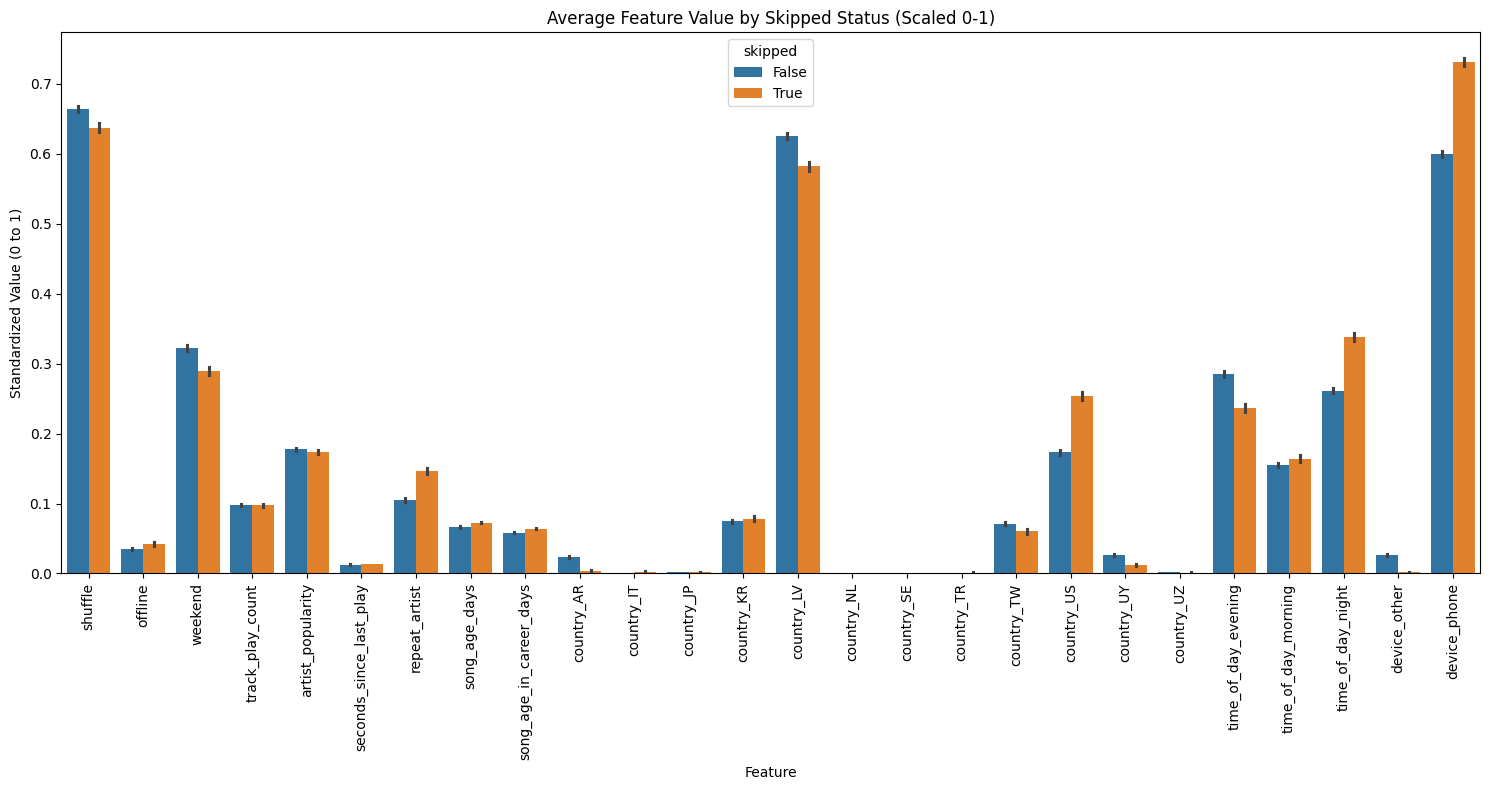

In [ ]:
# Load neccesarry libraries and modules
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Scale all features to a 0-1 range
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(model_data), columns=model_data.columns)

# Add the 'skipped' column back for grouping
data_scaled['skipped'] = model_data['skipped'].values

# Reshape the data from a wide format to a long format
data_melted = data_scaled.melt(id_vars='skipped', var_name='Feature', value_name='Scaled Value')

# Create a bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x='Feature', y='Scaled Value', hue='skipped', data=data_melted)
plt.xticks(rotation=90)
plt.title('Average Feature Value by Skipped Status (Scaled 0-1)')
plt.xlabel('Feature')
plt.ylabel('Standardized Value (0 to 1)')
plt.tight_layout()
plt.show()

Combined with the correlation matrix and the average feature value comparison across skipped and non-skipped songs, the plot above shows that the differences are small for many features, indicating that skips are influenced by multiple factors rather than a single dominant feature.

## Splitting Data

To prepare the data for modeling, I separate the predictor variables (X) from the target variable (y). I then use an 80/20 split to split the data into training and test sets using `train_test_split` method from the `sklearn.model_selection` module. The training set will be used for model fitting and validation, while the test set will be the unseen data to evaluate generalization performance.

In [ ]:
# Load neccesarry module
from sklearn.model_selection import train_test_split

# Separate the features (X) from the target (y)
X = model_data.drop(columns=['skipped']) 
y = model_data['skipped']

# Create the data split (80% for train/validation, 20% for test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20,
    random_state=37
)

# Print proportions of the resulting datasets
print(f"X_train proportion: {len(X_train) / (len(X_train) + len(X_test))}")
print(f"X_test proportion:  {len(X_test) / (len(X_train) + len(X_test))}")

print(f"\ny_train proportion: {len(y_train) / (len(y_train) + len(y_test))}")
print(f"y_test proportion:  {len(y_test) / (len(y_train) + len(y_test))}")

X_train proportion: 0.7999945443138111
X_test proportion:  0.20000545568618894

y_train proportion: 0.7999945443138111
y_test proportion:  0.20000545568618894


The output of the code cell above confirms that the split has been made and the train/test proportion is approximately 80/20.

## Selecting A Model 

Based on the problem statement, I have chosen **Random Forest Classifier** from the `sklearn.ensemble` module to classify whether a song will be skipped (`True`) or not skipped (`False`). On a high level, Random Forest is an *ensemle* learning method that builds multiple independent decision trees and combines their predictions to create the best-identified model. 

A decision tree is an algorithm that, at each node, tries to find the single best question (or "split") to ask about a feature to best separate the skipped from the non-skipped songs. To quantify "best", it uses a metric called *Gini Impurity*, which measures the probability of incorrectly classifying a randomly chosen element in a subset if it were randomly labeled according to the distribution of labels in that subset. The formula for Gini Impurity is:

$$
Gini = 1 - \sum_{i=1}^{C} (p_i)^2,
$$

where $C$ is the number of categories (in this case, 2: skipped and non-skipped), $p_i$ is the proportion of samples belonging to category $i$ within the subset.

A Gini score of 0 indicates a perfectly pure node (all samples are of one category), while a score of 0.5 represents a 50/50 split with maximum impurity. Decision tree algorithm's objective is to find the feature and split-point that results in the lowest weighted average Gini Impurity in the two resulting child nodes. It systematically evaluates potential splits for each feature and selects the one that provides the largest reduction in impurity (also known as *Information Gain*).

The Random Forest algorithm combines hundreds of diverse decision trees into a single model (ensemble). The final parameters of the model is determined by a majority vote from all individual trees. The advantage of the Random Forest comes from the way it introduces randomness to decorrelate the trees.

There are two key techniques employed to ensure the trees are different from one another:

* *Bootstrap Aggregating (Bagging)*: Each individual tree is not trained on the entire training set. Instead, it is trained on a random sample of the data drawn with replacement. 
* *Feature Subspacing*: This is the "random" element. At each node in a tree, when the algorithm searches for the best split, it does not evaluate all available features. Instead, it first selects a random subset of features. It then proceeds with the *Gini Impurity* calculation to find the best split only within that random subset. It tries *all possible* splits for the chosen features on the chosen datapoints, preventing all trees from becoming reliant on the same few dominant features and requiring them to explore a broader range of predictive patterns and creating a more robust collective model.

In the code cell below, my initial model is configured with `n_estimators=100`, meaning it will construct an ensemble of 100 individual decision trees. The parameters `max_depth=15` and `min_samples_leaf=5` are ways to prevent the trees from overfitting the data. `n_jobs=-1` tells the computer to use all available CPU cores for building the model. 

To get a reliable estimate of the model's performance on unseen data, I employ 5-fold cross-validation on the training set. This technique splits the training data into 5 equal "folds." The model is trained 5 times, each time using 4 folds for training and the remaining 1 for validation. The final performance score is the average of the scores from these 5 rounds, providing a stable estimate of the model's generalization capability.

Because I want to eliminate songs I don’t enjoy (i.e., accurately predict which songs I will skip), my goal is to minimize the number of false negatives (cases where the model fails to identify a song I would skip). In other words, I want the model to correctly classify skipped songs as skips as often as possible. Therefore, I use recall as the main evaluation metric, since it measures the proportion of actual positive cases (skipped songs) correctly identified by the model.

**Note**: Increasing recall usually decreases precision (i.e., increases the proportion of false positives), but I am willing to accept this trade-off because the cost of getting a song I don’t like is higher than the cost of missing a song I might enjoy.

In [ ]:
# Import necessary modules
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Initialize a Random Forest model
initial_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# Evaluate the model using 5-fold cross-validation
scores = cross_val_score(
    estimator=initial_model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# Show average performance
print(f"Average Recall: {scores.mean():.3f} +/- {scores.std():.3f}")

# Train the model on the training set
initial_model.fit(X_train, y_train)

# Evaluate the model
y_pred = initial_model.predict(X_test)
print(classification_report(y_test, y_pred))

Average Recall: 0.264 +/- 0.003
              precision    recall  f1-score   support

       False       0.75      0.97      0.85     10205
        True       0.80      0.26      0.40      4459

    accuracy                           0.76     14664
   macro avg       0.77      0.62      0.62     14664
weighted avg       0.77      0.76      0.71     14664



The results from the initial Random Forest model confirm the concerns created by the imbalanced nature of the dataset. The 5-fold cross-validation yielded an average recall of 0.264, indicating that, on average, the model is only able to correctly identify about 26% of the songs I would actually skip.

The `classification_report` also confirms the poor performance, as it shows a recall of 0.26 for the `True` (skipped) class. While the precision is high (0.80), the low recall means the model fails at what I want it to do the most and is too biased towards the majority "non-skipped" category.

Let's visualize the confusion matrix of the initial model.

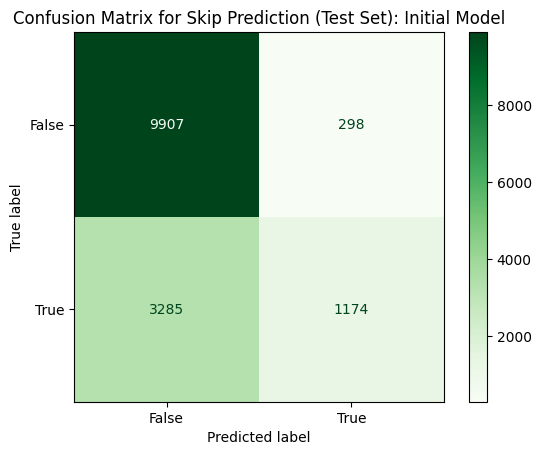

In [59]:
# Create and display the confusion matrix for the initial model
ConfusionMatrixDisplay.from_estimator(
    initial_model, 
    X_test, 
    y_test,
    cmap=plt.cm.Greens
)
plt.title('Confusion Matrix for Skip Prediction (Test Set): Initial Model')
plt.show()

The confusion matrix aligns with the classification report and shows that there are far more false negatives (3285) than true positives (1174), which does not satisfy the goals of the project. 

## Creating A Weighted Model

To address the issue of category imbalance, I build a second Random Forest Classifier model with setting the `class_weight` parameter to `balanced`.

It modifies the weight of each sample in the *Gini Impurity* calculation, giving a higher weight to samples from the minority class ("skipped") and a lower weight to the majority class ("non-skipped"), increasing the penalty for misclassifying a "skip". The expectation is that this will lead to an improvement in recall.

In [60]:
# Initialize a weighted Random Forest model
weighted_model = RandomForestClassifier(
    n_estimators=100,      
    max_depth=15,          
    min_samples_leaf=5,    
    random_state=42,       
    n_jobs=-1,
    class_weight='balanced'
)

# Evaluate the weighted model using 5-fold cross-validation
scores = cross_val_score(
    estimator=weighted_model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# Show average performance
print(f"Average Recall: {scores.mean():.3f} +/- {scores.std():.3f}")

# Train the weighted model on the training set
weighted_model.fit(X_train, y_train)

# Evaluate the weighted model
y_pred = weighted_model.predict(X_test)
print(classification_report(y_test, y_pred))

Average Recall: 0.630 +/- 0.009
              precision    recall  f1-score   support

       False       0.83      0.76      0.79     10205
        True       0.53      0.64      0.58      4459

    accuracy                           0.72     14664
   macro avg       0.68      0.70      0.69     14664
weighted avg       0.74      0.72      0.73     14664



As seen above, introducing `class_weight='balanced'` significantly improved model performance. The 5-fold cross-validation recall rose from 0.264 to 0.630, and the final test recall is now 0.64 for the `True` (skipped) category, meaning the model now correctly identifies approximately 64% of the songs I would skip.

As expected, the gain in recall came with reduced precision (from 0.80 to 0.53), but the F1-score increased from 0.40 to 0.58, confirming a better balance between precision and recall. Overall, the model is now much more effective at its main goal: detecting songs I’m likely to skip.

Let's visualize the confusion matrix for the weighted model.

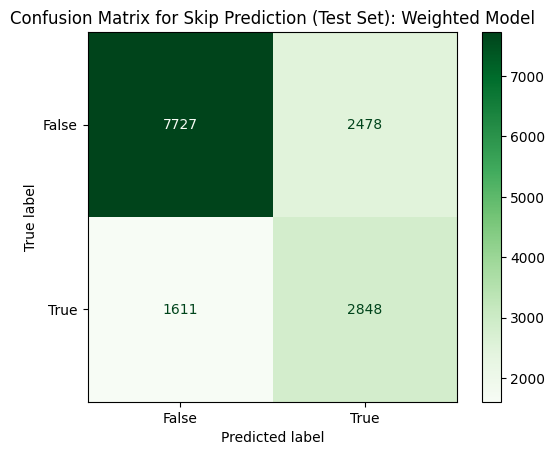

In [61]:
# Create and display the confusion matrix for the weighted model
ConfusionMatrixDisplay.from_estimator(
    weighted_model, 
    X_test, 
    y_test,
    cmap=plt.cm.Greens
)
plt.title('Confusion Matrix for Skip Prediction (Test Set): Weighted Model')
plt.show()

The changes in the confusion matrix also align with the changes in the recall values, showing that the true positives increased (2848 instead of 1174), while false negatives decreased (1611 instead of 3285), getting me closer to what I want the model to do. Additionally, as implied in the discussion on precision, the false positives also increased (2478 instead of 298), while true negatives decreased (7727 instead of 9907) due to the weighing of the model. 

## Hyperparameter Tuning

While the weighted Random Forest model performed better, I chose its initial configuration arbitrarily. To systematically find the optimal combination of these settings (hyperparameters), I perform a principled search using `Optuna`, an optimization framework to explore different combinations of hyperparameters to maximize recall.

Instead of testing every combination (Grid Search) or choosing randomly, `Optuna` uses bayesian optimization, a more efficient approach. It learns from past trials to make increasingly informed decisions about which hyperparameter combinations to test next, focusing on the most promising areas of the search space.

The optimization is done by an `Optuna` study, which runs a series of trials:

1. Initial Exploration (First Trials): The first few trials are random, sampling diverse points in the search space.
2. Building a Probabilistic Model: After each trial, the objective function trains a Random Forest with the suggested hyperparameters and returns its average 5-fold cross-validation recall. `Optuna` records these results and builds an internal surrogate model, mapping hyperparameters to performance scores.
3. Informed Exploitation (Later Trials): Subsequent trials use this surrogate model to balance exploitation (testing promising regions) and exploration (testing less-explored areas). `Optuna` selects hyperparameters most likely to improve recall based on this learned model.

This iterative search is more efficient than random guessing. The study, configured with `direction='maximize'`, performs this workflow. Running `study.optimize(objective, n_trials=20)` tells `Optuna` to perform 20 trials of this informed search.

I also extract the best-performing hyperparameters from the study, which are used to train a final Random Forest on the full training dataset. This model represents the best possible solution given the data and is evaluated on the held-out test set for an unbiased assessment of performance.

In [ ]:
# Import necessary libraries
import optuna

# Disable trial logging
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define the objective function for Optuna
def objective(trial):
    """
    Takes a "trial" object, suggests hyperparameters, trains a model, and returns a performance score.
    """

    # Define the search space for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    
    # Initialize the model with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # Get average ROC AUC score using 5-fold cross-validation
    score = cross_val_score(
        model, 
        X_train, 
        y_train, 
        scoring='recall',
        cv=5,
        n_jobs=-1
    ).mean()
    
    return score

# Create a study object and run the optimization with Optuna (20 trials)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best results from the study
print(f"Best cross-validated recall score: {study.best_trial.value:.3f}")
print("Best hyperparameters found:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Train the final model with the best hyperparameters
best_params = study.best_trial.params
final_model = RandomForestClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
print("Final Model Metrics")
y_pred_tuned = final_model.predict(X_test)
print(classification_report(y_test, y_pred_tuned))

Best cross-validated recall score: 0.663
Best hyperparameters found:
  n_estimators: 410
  max_depth: 11
  min_samples_leaf: 12
  min_samples_split: 9
Final Model Metrics
              precision    recall  f1-score   support

       False       0.83      0.70      0.76     10205
        True       0.49      0.67      0.57      4459

    accuracy                           0.69     14664
   macro avg       0.66      0.68      0.66     14664
weighted avg       0.73      0.69      0.70     14664



The hyperparameter tuning process with `Optuna` has successfully identified hyperparameters that improved recall upon the previous weighted Random Forest. After 20 trials, the best cross-validated recall of 0.663 was achieved with the following hyperparameters:

* `n_estimators`: 410
* `max_depth`: 11
* `min_samples_leaf`: 12
* `min_samples_split`: 9

The recall of 0.67 for the True (skipped) class is a modest but clear improvement over the 0.64 recall from the previous model.

As expected, this also resulted in a decreased precision value (from 0.53 to 0.49), and the F1-score decreased slightly from 0.58 to 0.57, reflecting the trade-off in optimizing specifically for recall: the model is now better at identifying songs I will skip, even if it misclassifies more songs I would actually like.

With the code below, I show the confusion matrix resulting from the final model.

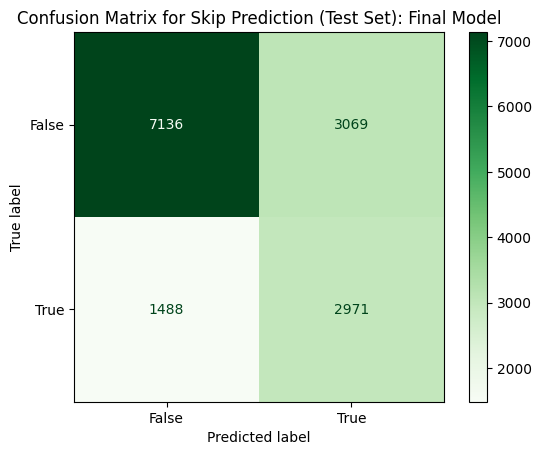

In [63]:
# Create and display the confusion matrix for the final model
ConfusionMatrixDisplay.from_estimator(
    final_model, 
    X_test, 
    y_test,
    cmap=plt.cm.Greens
)
plt.title('Confusion Matrix for Skip Prediction (Test Set): Final Model')
plt.show()

As seen above and on par with the updated recall value, the difference between true positives (2971) and false negatives (1488) is slightly higher than the difference in the weighted model (true positives: 2848, false negatives: 1611), though the change is relatively small. 

## Feature Importance

With tuning complete, the next step is to interpret how the model makes its predictions. Random Forests provide feature importance scores, which measure how much each feature reduces Gini Impurity across all trees. Higher scores indicate larger influence in distinguishing “skipped” from “non-skipped” songs.

The following code extracts the feature importance scores from the optimized model, sorts them in descending order, and visualizes the top 15 most influential features in a horizontal bar chart to show which factors most strongly "help" the model make predictions.

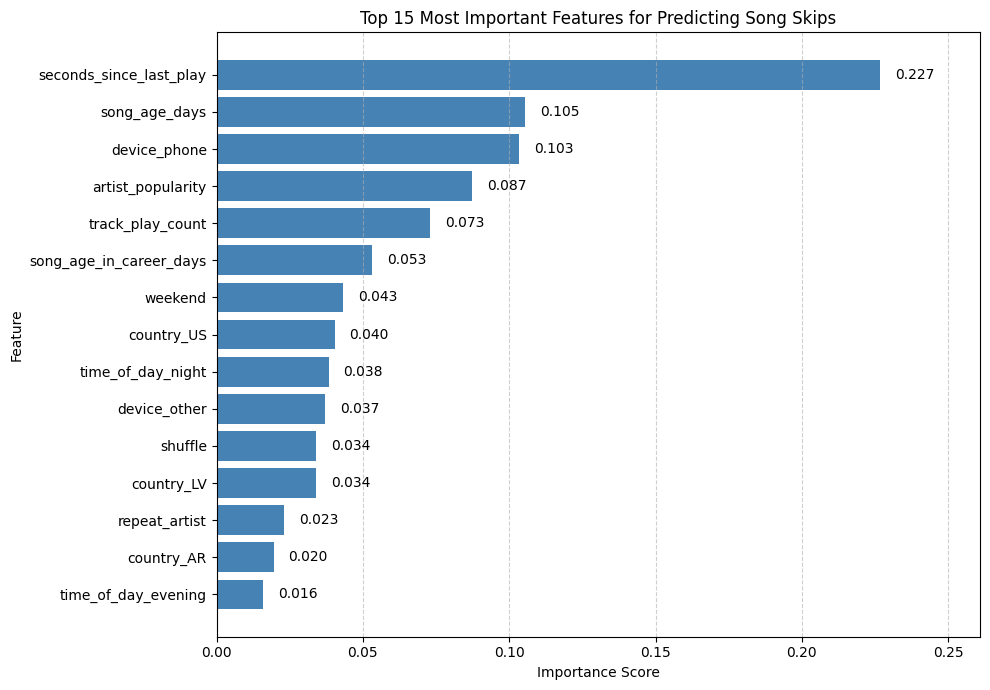

In [ ]:
# Get importance scores and feature names
importances = final_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance and select the top 15
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

# Plot feature importance with value labels
plt.figure(figsize=(10, 7))
bars = plt.barh(
    top_features['Feature'][::-1],
    top_features['Importance'][::-1],
    color='steelblue'
)
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f'{width:.3f}',
        va='center'
    )
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.title('Top 15 Most Important Features for Predicting Song Skips')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
max_importance = top_features['Importance'].max()
plt.xlim(0, max_importance * 1.15) 
plt.tight_layout()
plt.show()

The feature importance plot above shows that my skipping behavior is primarily driven by `seconds_since_last_play`, which dominates with a score of 0.227, over twice that of any other feature. A second group of features, `song_age_days` (0.105), `device_phone` (0.103), and `artist_popularity` (0.087), reflects the influence of song novelty, artist preference, and listening context.

To check the direction of the prediction from the first most important feature, I group data by how recently a song was played and calculate the average skip rate for each group in the code cell below. 

In [65]:
# Create a new column to categorize recency
def get_recency_category(seconds):
    if seconds < 3600: # Less than 1 hour
        return 'Very Recent'
    elif seconds < 86400: # Less than 1 day
        return 'Recent'
    else:
        return 'Not Recent'

model_data = model_data.copy()
model_data.loc[:, 'recency'] = model_data['seconds_since_last_play'].apply(get_recency_category)

# Calculate the average skip rate for each category
print(model_data.groupby('recency')['skipped'].mean())

recency
Not Recent     0.278174
Recent         0.232330
Very Recent    0.403325
Name: skipped, dtype: float64


The output of the code cell above shows that songs played within the last hour (`Very Recent`) have a 40.3% skip rate, which is much higher than for songs heard less recently. This confirms that the model correctly identified repetition fatigue as the primary driver for my skipping behavior, justifying why `seconds_since_last_play` is the most important predictive feature.

## Executive Summary

This project aimed to solve a personal annoyance: the somwhat constant need to skip songs on Spotify. The goal was to build a machine learning model using my own listening data that could predict whether I would skip a song. The initial plan to use audio features from Spotify's API was disturbed when the API access was disabled, forcing a pivot to a more focused challenge: *how accurately could I predict my own behavior using only my extended streaming history*?

The project had the following iterative pipeline:

![Process Pipeline](images/process_pipeline.png)

1. I began by retrieving my entire listening history from Spotify, which came as a series of JSON files. After parsing this data, I performed feature engineering to create meaningful predictors. This involved extracting time-based features, calculating song and artist popularity based on my own listening patterns, and creating features that captured context.
2. With the data prepared, I developed a series of models to find the best solution.
    * First, an initial Random Forest model showed that due to the imbalanced nature of my data (I don't skip most songs), the model had a recall of only 0.26. It was failing to identify the very songs I wanted it to find.
    * To fix this, I introduced a weighted Random Forest model using the `class_weight='balanced'` parameter. This allowed the model to pay more attention to the minority "skipped" class, resulting in an improvement in performance. The recall increased to 0.64, confirming this was a good approach.
    * Finally, to get best possible performance, I performed hyperparameter tuning using `Optuna`. This search process optimized the model's settings to maximize recall, ultimately getting the final model's recall at 0.67.
3. The feature importance analysis of the final model showed that the single most powerful predictor of a skip is repetition fatigue; the `seconds_since_last_play` feature was more than twice as important as any other. Secondary drivers included the song's age, my personal popularity score for the artist, and the listening device (specifically, whether I was on my phone).

While the final model is a strong proof of concept, it has its limitations. A recall of 0.67 means it still misses about a third of the songs I'd skip, and this performance comes at the cost of lower precision. I believe the biggest improvement would come from access to the audio features I originally planned to use. Future work could also explore more advanced models like Gradient Boosting or engineer more complex "session-based" features to better understand the context of my listening.

*AI Statement*: Throughout this assignment, I engaged with Google's Gemini as an interactive partner to increase my understanding and navigate the complexities of the machine learning workflow. My use of the AI was not to find direct answers, but rather to facilitate a more dynamic learning process. For instance, in the initial stages, I used it for brainstorming different modeling approaches and validating my choice of a Random Forest for this specific problem. When deciding on an evaluation metric, I discussed the nuances of my imbalanced dataset with the AI, which helped me understand why prioritizing recall was more appropriate than using accuracy or ROC AUC. While the AI helped with generating code for functions like the Optuna objective function, my role was to adapt, integrate, and own that code within the project's logic. This process was most helpful during debugging and result interpretation, where I could present the AI with an error message or code cell output and use its feedback to construct a more insightful narrative from the model's output.